<h1> Attrition Model Building Project </h1>
<h2> Problem Statement </h2>
HRBP 로서 Attrition 관리의 중요성을 알고 퇴사하는 임직원에 대한 데이터를 검토 후 퇴사에 영향을 미치는 Factor 를 분석하여
퇴사확율을 구하여 해당 인력의 퇴사 가능성을 낮추는 데 분석의 목적이 있다.

## Dataset Load & EDA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 데이터 불러오기
df = pd.read_excel("resources/ATTRITION DATA.xlsx")
df.head(2)

,e_code,status,hire_date,service_agreement,job_level,performance_rating_2018,performance_rating_2017,year_of_birth,gender,distance_from_home,...,potential_rating,bonus,no_courses_taken,time_in_position,awards,signon,manager_sat,employee_sat,salary_2017,salary_2018
0,45631,0,1990-09-17,N,3,4,3,1967,M,0.52,...,5,0,8,30,N,N,81,80,119968,124173
1,45632,0,1995-10-23,N,2,1,2,1971,M,0.08,...,5,2242,6,5,N,N,88,84,99330,100822


In [3]:
df.status.value_counts()

0    516
1    170
Name: status, dtype: int64

In [4]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df=df,minimal=True)
profile.to_widgets()

Render widgets: 100%|██████████| 1/1 [00:13<00:00, 13.25s/it]

## Feature Engineering

In [5]:
# Feature Engineering
df["var_rating"] = df["performance_rating_2018"] - df["performance_rating_2017"]
df["percentage_salary_change"] = (df["salary_2018"]-df["salary_2017"]) / df["salary_2017"] * 100
df["age"] = 2018-df["year_of_birth"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   e_code                    686 non-null    int64         
 1   status                    686 non-null    int64         
 2   hire_date                 686 non-null    datetime64[ns]
 3   service_agreement         686 non-null    object        
 4   job_level                 686 non-null    int64         
 5   performance_rating_2018   686 non-null    int64         
 6   performance_rating_2017   686 non-null    int64         
 7   year_of_birth             686 non-null    int64         
 8   gender                    686 non-null    object        
 9   distance_from_home        686 non-null    float64       
 10  manager_changes           686 non-null    int64         
 11  no_of_promotions          686 non-null    int64         
 12  risk_of_attrition     

In [6]:
# Variable Reduction
# 분석에 필요한 "변수 외 사용하지 않을 변수들에 대해서는 제거한다.
df = df.drop(columns=['year_of_birth',"performance_rating_2018","performance_rating_2017","salary_2017","salary_2018","hire_date","e_code"])

In [7]:
#변수 타입 변경
df = df.astype({"status" : "category","job_level" : "category","no_of_promotions" : "category","risk_of_attrition" : "category","potential_rating" : "category","var_rating":"category"})
df.dtypes

status                      category
service_agreement             object
job_level                   category
gender                        object
distance_from_home           float64
manager_changes                int64
no_of_promotions            category
risk_of_attrition           category
potential_rating            category
bonus                          int64
no_courses_taken               int64
time_in_position               int64
awards                        object
signon                        object
manager_sat                    int64
employee_sat                   int64
var_rating                  category
percentage_salary_change     float64
age                            int64
dtype: object

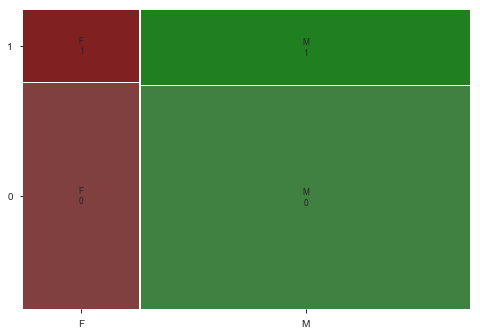

In [8]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df,["gender","status"])
plt.show()

## 카이제곱 검정

In [16]:
def crosstab_multi (x,y) : 
    print (pd.crosstab(x,y),"\n\n",pd.crosstab(x,y,normalize="index"),"\n\n",pd.crosstab(x,y,normalize="columns"))

In [17]:
crosstab_multi (df["status"],df['gender'])

gender    F    M
status          
0       136  380
1        43  127 

 gender         F         M
status                    
0       0.263566  0.736434
1       0.252941  0.747059 

 gender         F         M
status                    
0       0.759777  0.749507
1       0.240223  0.250493


In [18]:
from scipy import stats

In [19]:
# 카이 제곱 검정을 빠르게 하도록 함수 설정
def chi_multi (x, y) :
    for i in x : #카이제곱 검정을 실시하여 p-Value 추출
        y = y
        table = pd.crosstab(df[ i ], y)
        chi_table = stats.chi2_contingency(table)
        if chi_table[1] > 0.005 :  #p-value 값이 귀무가설을 기각하는 지 검증하여 프린트
            pass
        else : 
            print ("귀무가설 기각 / p-value between",i ,"and", y.name," : ", chi_table[1])

In [20]:
chi_multi (list(df.columns.values), df["status"])

귀무가설 기각 / p-value between status and status  :  4.8361514559412625e-150
귀무가설 기각 / p-value between risk_of_attrition and status  :  3.944526151206098e-12
귀무가설 기각 / p-value between potential_rating and status  :  2.019545165087339e-05
귀무가설 기각 / p-value between no_courses_taken and status  :  3.911152449060662e-21
귀무가설 기각 / p-value between time_in_position and status  :  4.888814410957131e-05
귀무가설 기각 / p-value between awards and status  :  0.000875372103862832
귀무가설 기각 / p-value between manager_sat and status  :  3.8376510266153956e-63
귀무가설 기각 / p-value between employee_sat and status  :  2.053734365905802e-13
귀무가설 기각 / p-value between var_rating and status  :  0.0035318724704160947


## T-Test

In [21]:
ttest_result = pd.DataFrame()
stats.ttest_rel(df["manager_sat"],df['status'])[1]

0.0

## Variable Reduction

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   status                    686 non-null    category
 1   service_agreement         686 non-null    object  
 2   job_level                 686 non-null    category
 3   gender                    686 non-null    object  
 4   distance_from_home        686 non-null    float64 
 5   manager_changes           686 non-null    int64   
 6   no_of_promotions          686 non-null    category
 7   risk_of_attrition         686 non-null    category
 8   potential_rating          686 non-null    category
 9   bonus                     686 non-null    int64   
 10  no_courses_taken          686 non-null    int64   
 11  time_in_position          686 non-null    int64   
 12  awards                    686 non-null    object  
 13  signon                    686 non-null    object  

In [23]:
# p-value 가 낮은 값을 제거한다.
df = df.drop(columns=["gender","job_level","signon","age","manager_changes",'bonus','time_in_position'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   status                    686 non-null    category
 1   service_agreement         686 non-null    object  
 2   distance_from_home        686 non-null    float64 
 3   no_of_promotions          686 non-null    category
 4   risk_of_attrition         686 non-null    category
 5   potential_rating          686 non-null    category
 6   no_courses_taken          686 non-null    int64   
 7   awards                    686 non-null    object  
 8   manager_sat               686 non-null    int64   
 9   employee_sat              686 non-null    int64   
 10  var_rating                686 non-null    category
 11  percentage_salary_change  686 non-null    float64 
dtypes: category(5), float64(2), int64(3), object(2)
memory usage: 42.0+ KB


## Dummy variable creation

In [24]:
df = pd.get_dummies(df,drop_first=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance_from_home        686 non-null    float64
 1   no_courses_taken          686 non-null    int64  
 2   manager_sat               686 non-null    int64  
 3   employee_sat              686 non-null    int64  
 4   percentage_salary_change  686 non-null    float64
 5   status_1                  686 non-null    uint8  
 6   service_agreement_Y       686 non-null    uint8  
 7   no_of_promotions_1        686 non-null    uint8  
 8   no_of_promotions_2        686 non-null    uint8  
 9   no_of_promotions_3        686 non-null    uint8  
 10  no_of_promotions_4        686 non-null    uint8  
 11  no_of_promotions_5        686 non-null    uint8  
 12  no_of_promotions_6        686 non-null    uint8  
 13  no_of_promotions_7        686 non-null    uint8  
 14  no_of_prom

In [26]:
df = df.rename(columns={"var_rating_-1":"var_rating_minus_1"})
df.head()

,distance_from_home,no_courses_taken,manager_sat,employee_sat,percentage_salary_change,status_1,service_agreement_Y,no_of_promotions_1,no_of_promotions_2,no_of_promotions_3,...,risk_of_attrition_4,potential_rating_2,potential_rating_3,potential_rating_4,potential_rating_5,awards_Y,var_rating_minus_1,var_rating_0,var_rating_1,var_rating_2
0,0.52,8,81,80,3.505101,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0.08,6,88,84,1.502064,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,0.51,2,83,93,12.670835,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0.81,2,86,83,3.761866,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0.06,10,79,80,0.000000,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


## Data Split

In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,train_size = 0.7, random_state = 100)

In [28]:
train.shape

(480, 27)

In [29]:
test.shape

(206, 27)

In [30]:
train = train.astype({"status_1":"category"})
test = test.astype({"status_1":"category"})
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 565 to 520
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   distance_from_home        480 non-null    float64 
 1   no_courses_taken          480 non-null    int64   
 2   manager_sat               480 non-null    int64   
 3   employee_sat              480 non-null    int64   
 4   percentage_salary_change  480 non-null    float64 
 5   status_1                  480 non-null    category
 6   service_agreement_Y       480 non-null    uint8   
 7   no_of_promotions_1        480 non-null    uint8   
 8   no_of_promotions_2        480 non-null    uint8   
 9   no_of_promotions_3        480 non-null    uint8   
 10  no_of_promotions_4        480 non-null    uint8   
 11  no_of_promotions_5        480 non-null    uint8   
 12  no_of_promotions_6        480 non-null    uint8   
 13  no_of_promotions_7        480 non-null    uint8 

In [31]:
import statsmodels.api as sm

In [32]:
# 선형회귀를 위한 status 에 대한 전체의 p-value 확인
x = train
y = train["status_1"]
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               status_1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.608e+30
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:32:23   Log-Likelihood:                 15723.
No. Observations:                 480   AIC:                        -3.139e+04
Df Residuals:                     453   BIC:                        -3.128e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -3.747e-15   1.76e-15     -2.126      0.034   -7.21e-15   -2.83e-16
distance_from_home        6.549e-17   8.57e-18      7.640      0.000    4.86e-17    8.23e-17
no_courses_taken          -4.64e-17   2.56e-17     -1.814      0.070   -9.67e-17    3.88e-18
manager_sat               1.893e-16   1.55e-17     12.243      0.000    1.59e-16     2.2e-16
employee_sat             -1.543e-16   1.43e-17    -10.823      0.000   -1.82e-16   -1.26e-16
percentage_salary_change -5.074e-17   1.08e-17     -4.681      0.000    -7.2e-17   -2.94e-17
status_1                     1.0000   2.01e-16   4.98e+15      0.000       1.000       1.000
service_agreement_Y       6.019e-16   1.97e-16      3.056      0.002    2.15e-16    9.89e-16
no_of_promotions_1        2.151e-16   1.99e-16      1.078      0.281   -1.77e-16    6.07e-16
no_of_promotions_2       -4.302e-16   2.77e-16     -1.556      0.121   -9.74e-16    1.13e-16
no_of_promotions_3        2.776e-16   4.37e-16      0.636      0.525    -5.8e-16    1.14e-15
no_of_promotions_4       -4.163e-17   4.17e-16     -0.100      0.920   -8.61e-16    7.78e-16
no_of_promotions_5        1.839e-16   6.78e-16      0.271      0.786   -1.15e-15    1.52e-15
no_of_promotions_6        9.368e-17   1.51e-15      0.062      0.951   -2.88e-15    3.07e-15
no_of_promotions_7       -6.939e-18   1.07e-15     -0.006      0.995   -2.11e-15    2.09e-15
no_of_promotions_10       6.939e-17   1.53e-15      0.045      0.964   -2.93e-15    3.07e-15
risk_of_attrition_2      -1.041e-17   2.16e-16     -0.048      0.962   -4.35e-16    4.14e-16
risk_of_attrition_3       1.874e-16   2.13e-16      0.880      0.379   -2.31e-16    6.06e-16
risk_of_attrition_4      -4.025e-16   2.69e-16     -1.497      0.135   -9.31e-16    1.26e-16
potential_rating_2       -2.498e-16   2.96e-16     -0.843      0.400   -8.32e-16    3.33e-16
potential_rating_3        2.741e-16   1.79e-16      1.528      0.127   -7.84e-17    6.27e-16
potential_rating_4         1.11e-16   1.86e-16      0.596      0.551   -2.55e-16    4.77e-16
potential_rating_5       -4.441e-16   1.86e-16     -2.385      0.018    -8.1e-16   -7.81e-17
awards_Y                  3.469e-17    2.5e-16      0.139      0.890   -4.57e-16    5.26e-16
var_rating_minus_1        7.321e-16   5.28e-16      1.386      0.167   -3.06e-16    1.77e-15
var_rating_0                3.4e-16   5.09e-16      0.669      0.504   -6.59e-16    1.34e-15
var_rating_1              1.457e-16   5.15e-16      0.283      0.777   -8.67e-16    1.16e-15
var_rating_2             -2.394e-16   1.59e-15     -0.151      0.880   -3.36e-15    2.88e-15
==============================================================================
Omnibus:                       15.930   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Ja

In [33]:
# stepwise regression 에서 forward regression 함수 호출

def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            if (len(included) == 0):
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            else:
                model = sm.OLS(y, pd.DataFrame(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [34]:
model = train[forward_regression(x,y,threshold_in=0.05)]
model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 565 to 520
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   status_1                  480 non-null    category
 1   no_of_promotions_3        480 non-null    uint8   
 2   percentage_salary_change  480 non-null    float64 
 3   employee_sat              480 non-null    int64   
 4   manager_sat               480 non-null    int64   
 5   no_courses_taken          480 non-null    int64   
 6   var_rating_0              480 non-null    uint8   
 7   risk_of_attrition_3       480 non-null    uint8   
 8   potential_rating_3        480 non-null    uint8   
 9   service_agreement_Y       480 non-null    uint8   
 10  var_rating_1              480 non-null    uint8   
 11  distance_from_home        480 non-null    float64 
 12  no_of_promotions_1        480 non-null    uint8   
dtypes: category(1), float64(2), int64(3), uint8(7)
m